<a href="https://colab.research.google.com/github/BioGeMT/DLforGenomics/blob/dev/notebooks/Computing_k_mers_and_using_ML_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://raw.githubusercontent.com/BioGeMT/DLforGenomics/main/data/Helwak_2013/one_miRNA/miRNA_train_set.tsv -O miRNA_train_set.tsv

--2024-05-31 14:56:58--  https://raw.githubusercontent.com/BioGeMT/DLforGenomics/main/data/Helwak_2013/one_miRNA/miRNA_train_set.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 101082 (99K) [text/plain]
Saving to: ‘miRNA_train_set.tsv’

miRNA_train_set.tsv 100%[===================>]  98.71K  --.-KB/s    in 0.01s   

2024-05-31 14:56:58 (6.53 MB/s) - ‘miRNA_train_set.tsv’ saved [101082/101082]



## Dataset Exploration

In [ ]:
import pandas as pd

df = pd.read_csv('miRNA_train_set.tsv', sep='\t')
df

,gene,label
0,AGCACTGCCGCCGGGGACTGCTCAGCAACCACACCGGCAGCCCGCG...,1
1,CTTCTCGGAGACGGTGCGCATCATCAACCGCAAGGTGAAGCCGCGG...,1
2,GGGCTGGGCAAAGAATGTGCAAAAGTCTTCTATGCTGCGGGTGCTA...,1
3,TCCACTAGAAGGCTGGGACAGCACCGGTGATTACTGTCTTTCCTGC...,1
4,AGTTCACAGGCTTTGTGGACATGTGTGTGCAGCATATCCCTTCTCC...,1
...,...,...
1902,TCTAAGCCATCCAGTGCCATCCTCGTCGCTGCAGCGACACACGCTC...,0
1903,AACCACGTCTCCTACTTTCCAAACCCATGGCAGTGTCCCTGCTCCA...,0
1904,ATTGAAGCCTGCCCATCCTCCCATGAGAGACTCTTGTTAGTCAACA...,0
1905,GCCAGCCCTACACTCGCCCGCGCCATGGCCTCTGTCTCCGAGCTCG...,0


### K-mer Counts

In [ ]:
from collections import Counter

def generate_kmers(sequence, k):
    """Generate k-mers from a given sequence."""
    return [sequence[i:i+k] for i in range(len(sequence) - k + 1)]

def count_kmers(sequence, k):
    """Count k-mers in the given sequence."""
    kmers = generate_kmers(sequence, k)
    return Counter(kmers)

# Set the value of k
k = 6

# Apply the k-mer counting to each sequence in the DataFrame
df['kmer_counts'] = df['gene'].apply(lambda seq: count_kmers(seq, k))

# Display the first few rows of the DataFrame with k-mer counts
df.head()

,gene,label,kmer_counts
0,AGCACTGCCGCCGGGGACTGCTCAGCAACCACACCGGCAGCCCGCG...,1,"{'AGCACT': 1, 'GCACTG': 1, 'CACTGC': 1, 'ACTGC..."
1,CTTCTCGGAGACGGTGCGCATCATCAACCGCAAGGTGAAGCCGCGG...,1,"{'CTTCTC': 1, 'TTCTCG': 1, 'TCTCGG': 1, 'CTCGG..."
2,GGGCTGGGCAAAGAATGTGCAAAAGTCTTCTATGCTGCGGGTGCTA...,1,"{'GGGCTG': 1, 'GGCTGG': 1, 'GCTGGG': 1, 'CTGGG..."
3,TCCACTAGAAGGCTGGGACAGCACCGGTGATTACTGTCTTTCCTGC...,1,"{'TCCACT': 1, 'CCACTA': 1, 'CACTAG': 1, 'ACTAG..."
4,AGTTCACAGGCTTTGTGGACATGTGTGTGCAGCATATCCCTTCTCC...,1,"{'AGTTCA': 1, 'GTTCAC': 1, 'TTCACA': 1, 'TCACA..."


### K-mer Enrichment

In [ ]:
import pandas as pd
from collections import Counter
import numpy as np

def count_unique_kmers(sequence, k):
    """Count unique k-mers in the given sequence."""
    kmers = generate_kmers(sequence, k)
    return set(kmers)

# Apply the k-mer counting to each sequence in the DataFrame
df['unique_kmers'] = df['gene'].apply(lambda seq: count_unique_kmers(seq, k))

# Split the dataframe into two categories
category_1 = df[df['label'] == 1]['unique_kmers']
category_0 = df[df['label'] == 0]['unique_kmers']

# Count the presence of each k-mer in the samples of each category
presence_1 = Counter()
for kmers in category_1:
    presence_1.update(kmers)

presence_0 = Counter()
for kmers in category_0:
    presence_0.update(kmers)

# Calculate total number of samples in each category
total_samples_1 = len(category_1)
total_samples_0 = len(category_0)

# Calculate log2 fold change enrichment of k-mers in category 1 vs category 0
enrichment = []
for kmer in presence_1:
    count_1 = presence_1[kmer]
    count_0 = presence_0.get(kmer, 0)

    # Calculate percentage
    percent_1 = (count_1 / total_samples_1) * 100
    percent_0 = (count_0 / total_samples_0) * 100

    # Calculate log2 fold change
    fold_change = (count_1 + 1) / (count_0 + 1)  # Add pseudocounts to avoid division by zero
    log2_fold_change = np.log2(fold_change)
    enrichment.append((kmer, fold_change, log2_fold_change, percent_1, percent_0))

# Sort the k-mers by log2 fold change value
enrichment_sorted = sorted(enrichment, key=lambda x: x[1], reverse=True)

# Create a DataFrame to display the most enriched k-mers
enrichment_df = pd.DataFrame(enrichment_sorted, columns=['k-mer', 'FC', 'Log2FC', 'Percent Pos', 'Percent Neg'])
print(enrichment_df.head(20))

     k-mer         FC    Log2FC  Percent Pos  Percent Neg
0   CCGGGA  11.090909  3.471306    12.845011     1.036269
1   TGCGCA  10.000000  3.321928     0.955414     0.000000
2   GTGCAA   9.428571  3.237039     6.900212     0.621762
3   GGCCGG   9.142857  3.192645    13.481953     1.347150
4   CGGGAT   9.000000  3.169925     2.760085     0.207254
5   GCCGGG   8.588235  3.102362    15.392781     1.658031
6   AGGCCG   8.545455  3.095157     9.872611     1.036269
7   CGGGAC   8.090909  3.016302     9.341826     1.036269
8   AGTGCA   7.400000  2.887525     7.749469     0.932642
9   TGCCGG   7.400000  2.887525     3.821656     0.414508
10  TCGGGA   7.000000  2.807355     3.609342     0.414508
11  GCGTCC   7.000000  2.807355     0.636943     0.000000
12  TACGCC   7.000000  2.807355     0.636943     0.000000
13  GGACAA   6.545455  2.710493     7.537155     1.036269
14  AAGCCG   6.500000  2.700440     1.273885     0.103627
15  ACGAGT   6.500000  2.700440     1.273885     0.103627
16  CAACGT   6

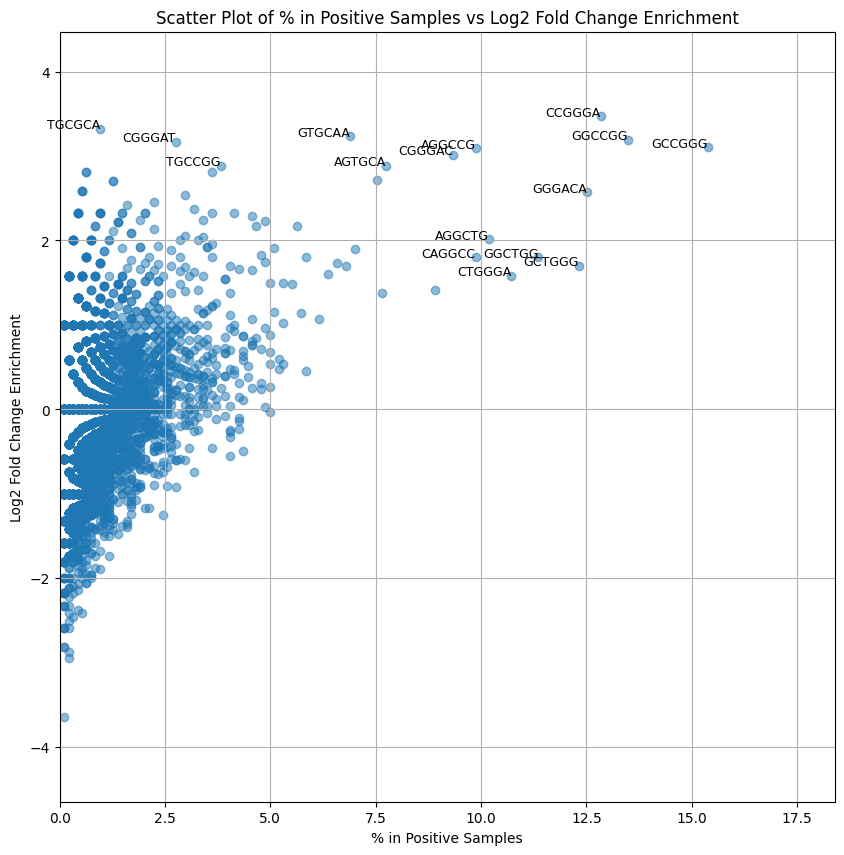

In [ ]:
import matplotlib.pyplot as plt

# Extract most extreme k-mers
extreme_kmers_log2fc = enrichment_df.nlargest(10, 'Log2FC')
extreme_kmers_count_pos = enrichment_df.nlargest(10, 'Percent Pos')

# Combine and remove duplicates
extreme_kmers = pd.concat([extreme_kmers_log2fc, extreme_kmers_count_pos]).drop_duplicates()

# Create scatter plot
plt.figure(figsize=(10, 10))
plt.scatter(enrichment_df['Percent Pos'], enrichment_df['Log2FC'], alpha=0.5)

# Annotate most extreme k-mers
for i, row in extreme_kmers.iterrows():
    plt.annotate(row['k-mer'], (row['Percent Pos'], row['Log2FC']), fontsize=9, ha='right')

# Add labels and title
plt.xlabel('% in Positive Samples')
plt.ylabel('Log2 Fold Change Enrichment')
plt.title('Scatter Plot of % in Positive Samples vs Log2 Fold Change Enrichment')
plt.grid(True)
plt.xlim(0, max(enrichment_df['Percent Pos']) + 3)
plt.ylim(min(enrichment_df['Log2FC']) - 1, max(enrichment_df['Log2FC']) + 1)

# Show plot
plt.show()


### microRNA seed

miR: TATTGCACTTGTCCCGGCCT >>> AGGCCGGGACAAGTGCAATA
seed: ATTGCA >>> TGCAAT


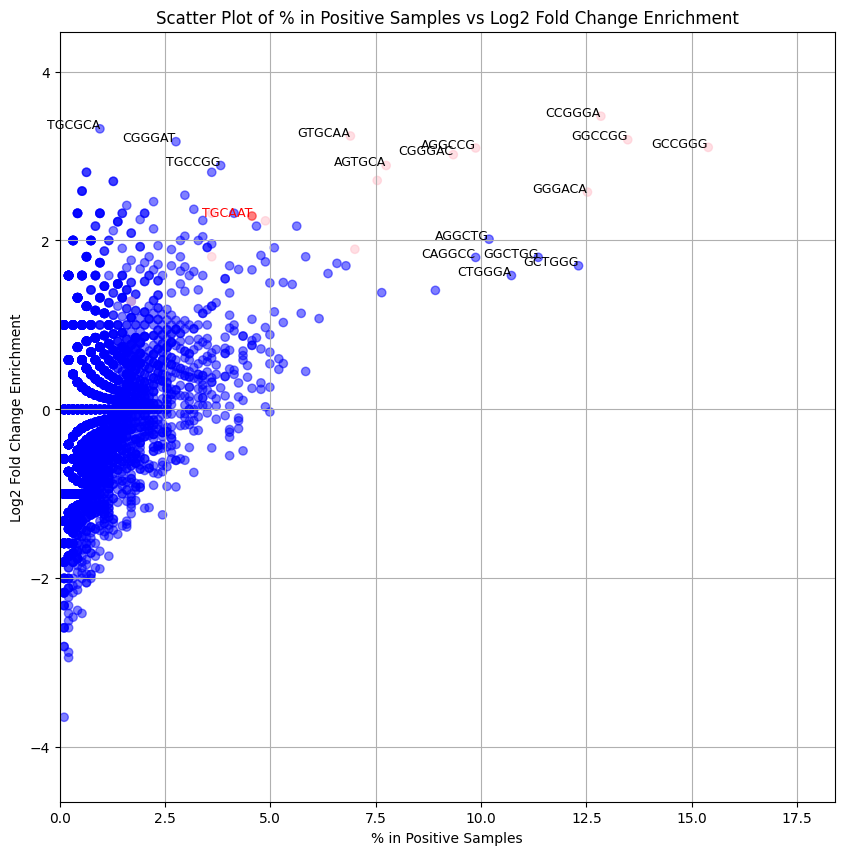

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Function to get the reverse complement of a sequence
def reverse_complement(seq):
    complement = {'A': 'T', 'C': 'G', 'G': 'C', 'T': 'A'}
    return ''.join(complement[base] for base in reversed(seq))

# miRNA sequence
miRNA_sequence = 'TATTGCACTTGTCCCGGCCT'
print('miR:', miRNA_sequence, ">>>", reverse_complement(miRNA_sequence))

# Identify the 6-mer seed region in the miRNA sequence (typically positions 2-7)
miRNA_seed = miRNA_sequence[1:7]
miRNA_seed_complement = reverse_complement(miRNA_seed)

print('seed:', miRNA_seed, ">>>", miRNA_seed_complement)

# Find any 6-mer within the miRNA sequence that is complementary
complementary_kmers = []
for i in range(len(miRNA_sequence) - 5):
    kmer = miRNA_sequence[i:i+6]
    kmer_complement = reverse_complement(kmer)
    complementary_kmers.append(kmer_complement)

# Remove duplicates
complementary_kmers = set(complementary_kmers)

# Create scatter plot with initial settings
plt.figure(figsize=(10, 10))

# Loop through the DataFrame and change the color of the dots based on the condition
colors = []
for i, row in enrichment_df.iterrows():
    if row['k-mer'] == miRNA_seed_complement:
        colors.append('red')
    elif row['k-mer'] in complementary_kmers:
        colors.append('pink')
    else:
        colors.append('blue')  # Default color for non-matching k-mers

# Plot with colors
plt.scatter(enrichment_df['Percent Pos'], enrichment_df['Log2FC'], c=colors, alpha=0.5)

# Annotate the most extreme k-mers
for i, row in extreme_kmers.iterrows():
    plt.annotate(row['k-mer'], (row['Percent Pos'], row['Log2FC']), fontsize=9, ha='right')

# Additional line to specifically annotate the miRNA_seed_complement
for i, row in enrichment_df.iterrows():
    if row['k-mer'] == miRNA_seed_complement:
        plt.annotate(row['k-mer'], (row['Percent Pos'], row['Log2FC']), fontsize=9, ha='right', color='red')

# Add labels and title
plt.xlabel('% in Positive Samples')
plt.ylabel('Log2 Fold Change Enrichment')
plt.title('Scatter Plot of % in Positive Samples vs Log2 Fold Change Enrichment')
plt.grid(True)
plt.xlim(0, max(enrichment_df['Percent Pos']) + 3)
plt.ylim(min(enrichment_df['Log2FC']) - 1, max(enrichment_df['Log2FC']) + 1)

# Show plot
plt.show()


# Machine Learning Approaches

### Split data in train and test

In [ ]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Prepare the feature matrix
vectorizer = DictVectorizer(sparse=False)
X = vectorizer.fit_transform(df['kmer_counts'])

# Prepare the labels
y = df['label']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)



### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

# Train a LOGISTIC REGRESSION classifier
lr_classifier = LogisticRegression(max_iter=1000, random_state=42)
lr_classifier.fit(X_train, y_train)

# Make predictions with LOGISTIC REGRESSION
lr_y_pred = lr_classifier.predict(X_test)

# Evaluate the LOGISTIC REGRESSION classifier
lr_accuracy = accuracy_score(y_test, lr_y_pred)
lr_report = classification_report(y_test, lr_y_pred)

print(f'Accuracy (Logistic Regression): {lr_accuracy}')
print('Classification Report (Logistic Regression):')
print(lr_report)

Accuracy (Logistic Regression): 0.7696335078534031
Classification Report (Logistic Regression):
              precision    recall  f1-score   support

           0       0.79      0.79      0.79       103
           1       0.75      0.75      0.75        88

    accuracy                           0.77       191
   macro avg       0.77      0.77      0.77       191
weighted avg       0.77      0.77      0.77       191



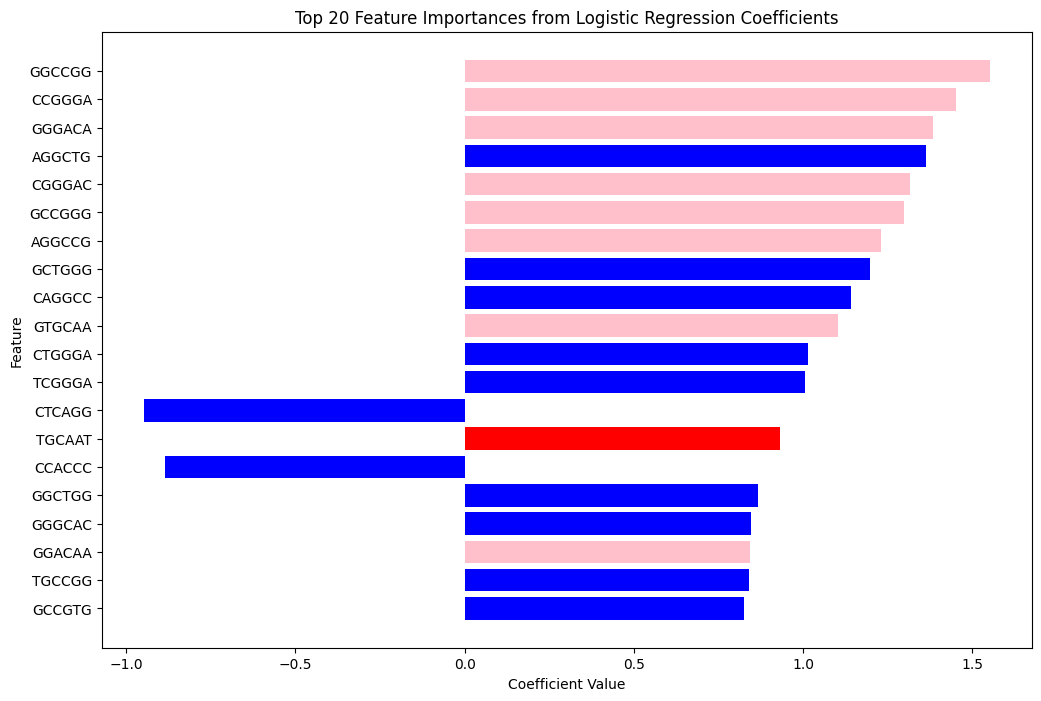

In [ ]:
# Get the coefficients (feature importances)
coefficients = lr_classifier.coef_.flatten()

# Create a DataFrame to display feature importances
feature_names = vectorizer.get_feature_names_out()  # Assuming you used DictVectorizer
feature_importances = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Sort features by absolute value of coefficients
feature_importances['Absolute Coefficient'] = feature_importances['Coefficient'].abs()
feature_importances = feature_importances.sort_values(by='Absolute Coefficient', ascending=False)

# Define colors based on feature types
colors = []
for feature in feature_importances['Feature'][:20]:
    if feature == miRNA_seed_complement:
        colors.append('red')
    elif feature in complementary_kmers:
        colors.append('pink')
    else:
        colors.append('blue')

# Plot the top 20 feature importances
plt.figure(figsize=(12, 8))
plt.barh(feature_importances['Feature'][:20], feature_importances['Coefficient'][:20], color=colors, align='center')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Top 20 Feature Importances from Logistic Regression Coefficients')
plt.gca().invert_yaxis()  # Reverse the order to have the highest importance at the top
plt.show()


### K Nearest Neighbours

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Train a K-NEAREST NEIGHBORS classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(X_train, y_train)

# Make predictions with K-NEAREST NEIGHBORS
knn_y_pred = knn_classifier.predict(X_test)

# Evaluate the K-NEAREST NEIGHBORS classifier
knn_accuracy = accuracy_score(y_test, knn_y_pred)
knn_report = classification_report(y_test, knn_y_pred)

print(f'Accuracy (K-Nearest Neighbors): {knn_accuracy}')
print('Classification Report (K-Nearest Neighbors):')
print(knn_report)

Accuracy (K-Nearest Neighbors): 0.6649214659685864
Classification Report (K-Nearest Neighbors):
              precision    recall  f1-score   support

           0       0.71      0.65      0.68       103
           1       0.62      0.68      0.65        88

    accuracy                           0.66       191
   macro avg       0.67      0.67      0.66       191
weighted avg       0.67      0.66      0.67       191



### Naive Bayes Classifier

In [ ]:
from sklearn.naive_bayes import MultinomialNB

# Train a NAIVE BAYES classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)

# Make predictions with NAIVE BAYES
nb_y_pred = nb_classifier.predict(X_test)

# Evaluate the NAIVE BAYES classifier
nb_accuracy = accuracy_score(y_test, nb_y_pred)
nb_report = classification_report(y_test, nb_y_pred)

print(f'Accuracy (Naive Bayes): {nb_accuracy}')
print('Classification Report (Naive Bayes):')
print(nb_report)

Accuracy (Naive Bayes): 0.7120418848167539
Classification Report (Naive Bayes):
              precision    recall  f1-score   support

           0       0.74      0.72      0.73       103
           1       0.68      0.70      0.69        88

    accuracy                           0.71       191
   macro avg       0.71      0.71      0.71       191
weighted avg       0.71      0.71      0.71       191



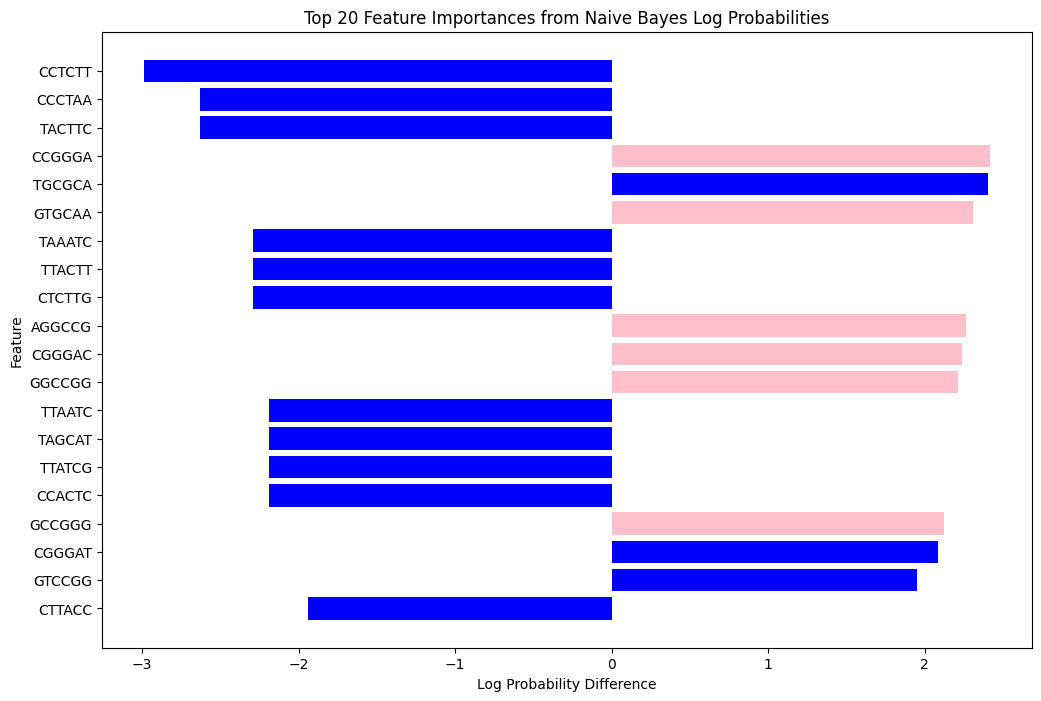

In [ ]:
import numpy as np
import pandas as pd

# Get the log probabilities of features given a class
feature_log_prob = nb_classifier.feature_log_prob_

# Create a DataFrame for feature importances
feature_names = vectorizer.get_feature_names_out()  # DictVectorizer
feature_importances = pd.DataFrame({
    'Feature': feature_names,
    'Log Probability Class 0': feature_log_prob[0],
    'Log Probability Class 1': feature_log_prob[1]
})

# Calculate the difference in log probabilities between the two classes
feature_importances['Log Probability Difference'] = feature_importances['Log Probability Class 1'] - feature_importances['Log Probability Class 0']

# Sort features by the absolute value of the log probability difference
feature_importances['Absolute Log Probability Difference'] = feature_importances['Log Probability Difference'].abs()
feature_importances = feature_importances.sort_values(by='Absolute Log Probability Difference', ascending=False)

# Define colors based on feature types
colors = []
for feature in feature_importances['Feature'][:20]:
    if feature == miRNA_seed_complement:
        colors.append('red')
    elif feature in complementary_kmers:
        colors.append('pink')
    else:
        colors.append('blue')

# Plot the top 20 feature importances
plt.figure(figsize=(12, 8))
plt.barh(feature_importances['Feature'][:20], feature_importances['Log Probability Difference'][:20], color=colors, align='center')
plt.xlabel('Log Probability Difference')
plt.ylabel('Feature')
plt.title('Top 20 Feature Importances from Naive Bayes Log Probabilities')
plt.gca().invert_yaxis()  # Reverse the order to have the highest importance at the top
plt.show()


### Perceptron

In [ ]:
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score, classification_report

# Train a PERCEPTRON classifier
perceptron_classifier = Perceptron(max_iter=1000, random_state=42)
perceptron_classifier.fit(X_train, y_train)

# Make predictions with PERCEPTRON
perceptron_y_pred = perceptron_classifier.predict(X_test)

# Evaluate the PERCEPTRON classifier
perceptron_accuracy = accuracy_score(y_test, perceptron_y_pred)
perceptron_report = classification_report(y_test, perceptron_y_pred)

print(f'Accuracy (Perceptron): {perceptron_accuracy}')
print('Classification Report (Perceptron):')
print(perceptron_report)


Accuracy (Perceptron): 0.6963350785340314
Classification Report (Perceptron):
              precision    recall  f1-score   support

           0       0.72      0.72      0.72       103
           1       0.67      0.67      0.67        88

    accuracy                           0.70       191
   macro avg       0.69      0.69      0.69       191
weighted avg       0.70      0.70      0.70       191



### Support Vector Machine

In [ ]:
from sklearn.svm import SVC

# Train a SVM classifier
svm_classifier = SVC(kernel='linear', random_state=42)
svm_classifier.fit(X_train, y_train)

# Make predictions with SVM
svm_y_pred = svm_classifier.predict(X_test)

# Evaluate the SVM classifier
svm_accuracy = accuracy_score(y_test, svm_y_pred)
svm_report = classification_report(y_test, svm_y_pred)

print(f'Accuracy (SVM): {svm_accuracy}')
print('Classification Report (SVM):')
print(svm_report)

Accuracy (SVM): 0.7329842931937173
Classification Report (SVM):
              precision    recall  f1-score   support

           0       0.76      0.74      0.75       103
           1       0.70      0.73      0.72        88

    accuracy                           0.73       191
   macro avg       0.73      0.73      0.73       191
weighted avg       0.73      0.73      0.73       191



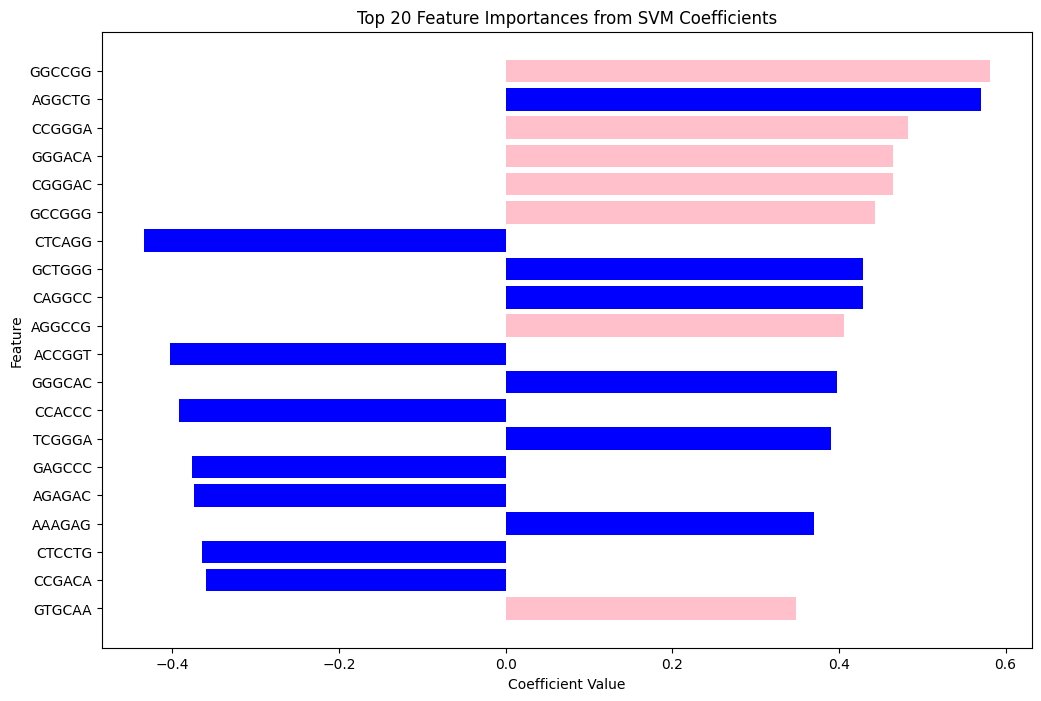

In [ ]:
# Get the coefficients (feature importances)
coefficients = svm_classifier.coef_.flatten()

# Create a DataFrame to display feature importances
feature_names = vectorizer.get_feature_names_out()  # Assuming you used DictVectorizer
feature_importances = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Sort features by absolute value of coefficients
feature_importances['Absolute Coefficient'] = feature_importances['Coefficient'].abs()
feature_importances = feature_importances.sort_values(by='Absolute Coefficient', ascending=False)

# Define colors based on feature types
colors = []
for feature in feature_importances['Feature'][:20]:
    if feature == miRNA_seed_complement:
        colors.append('red')
    elif feature in complementary_kmers:
        colors.append('pink')
    else:
        colors.append('blue')

# Plot the top 20 feature importances
plt.figure(figsize=(12, 8))
plt.barh(feature_importances['Feature'][:20], feature_importances['Coefficient'][:20], color=colors, align='center')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Top 20 Feature Importances from SVM Coefficients')
plt.gca().invert_yaxis()  # Reverse the order to have the highest importance at the top
plt.show()


### Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Train a DECISION TREE classifier
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train, y_train)

# Make predictions with DECISION TREE
dt_y_pred = dt_classifier.predict(X_test)

# Evaluate the DECISION TREE classifier
dt_accuracy = accuracy_score(y_test, dt_y_pred)
dt_report = classification_report(y_test, dt_y_pred)

print(f'Accuracy (Decision Tree): {dt_accuracy}')
print('Classification Report (Decision Tree):')
print(dt_report)

Accuracy (Decision Tree): 0.680628272251309
Classification Report (Decision Tree):
              precision    recall  f1-score   support

           0       0.74      0.62      0.68       103
           1       0.63      0.75      0.68        88

    accuracy                           0.68       191
   macro avg       0.69      0.69      0.68       191
weighted avg       0.69      0.68      0.68       191



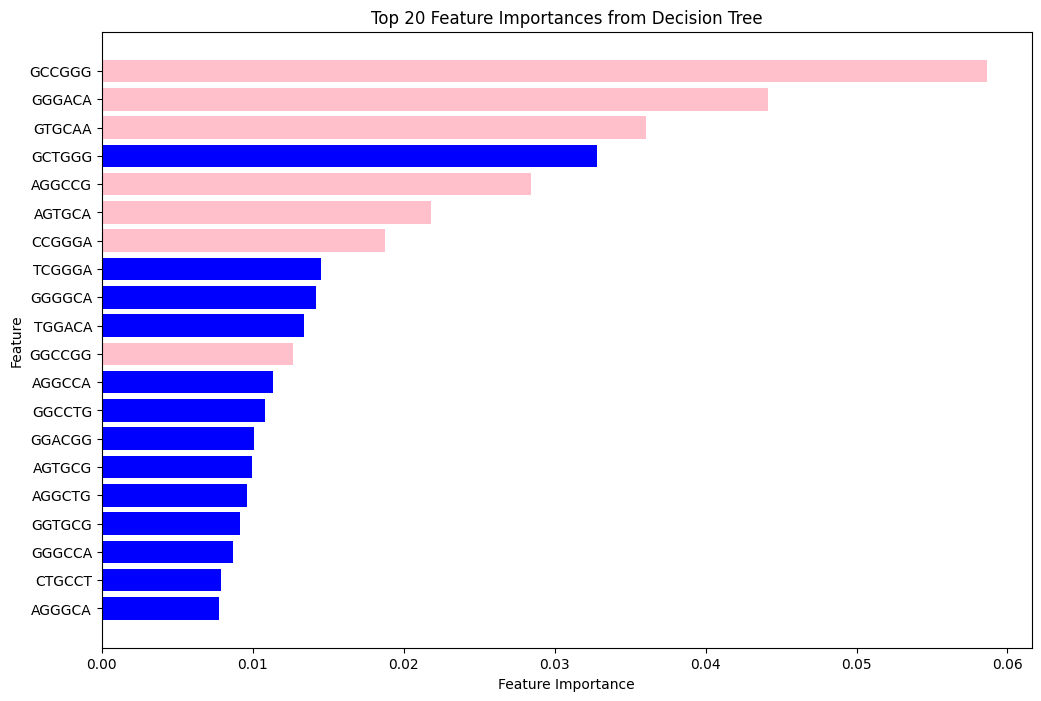

In [ ]:
# Get the feature importances
importances = dt_classifier.feature_importances_

# Create a DataFrame to display feature importances
feature_names = vectorizer.get_feature_names_out()  # Assuming you used DictVectorizer
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort features by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Define colors based on feature types
colors = []
for feature in feature_importances['Feature'][:20]:
    if feature == miRNA_seed_complement:
        colors.append('red')
    elif feature in complementary_kmers:
        colors.append('pink')
    else:
        colors.append('blue')

# Plot the top 20 feature importances
plt.figure(figsize=(12, 8))
plt.barh(feature_importances['Feature'][:20], feature_importances['Importance'][:20], color=colors, align='center')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 20 Feature Importances from Decision Tree')
plt.gca().invert_yaxis()  # Reverse the order to have the highest importance at the top
plt.show()


In [ ]:
from sklearn.tree import plot_tree

# Plot the tree structure (ATTN HUGE IMAGE)
plt.figure(figsize=(200, 100))
plot_tree(dt_classifier, feature_names=feature_names, class_names=True, filled=True, rounded=True)
plt.title('Decision Tree Structure')
plt.show()


KeyboardInterrupt: 

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Train a RANDOM FOREST classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Make predictions
rf_y_pred = rf_classifier.predict(X_test)

# Evaluate the classifier
rf_accuracy = accuracy_score(y_test, rf_y_pred)
rf_report = classification_report(y_test, rf_y_pred)

print(f'Accuracy (Random Forest): {rf_accuracy}')
print('Classification Report (Random Forest):')
print(rf_report)


Accuracy (Random Forest): 0.8115183246073299
Classification Report (Random Forest):
              precision    recall  f1-score   support

           0       0.87      0.77      0.81       103
           1       0.76      0.86      0.81        88

    accuracy                           0.81       191
   macro avg       0.81      0.82      0.81       191
weighted avg       0.82      0.81      0.81       191



EXERCISE: Iterate on all max_depth [1,40] and plot Accuracy per max_depth.

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Run multiple times to get error bars
n_runs = 5
importances_all = np.zeros((n_runs, len(feature_names)))

for i in range(n_runs):
    rf_classifier = RandomForestClassifier(n_estimators=100, random_state=i)
    rf_classifier.fit(X_train, y_train)
    importances_all[i] = rf_classifier.feature_importances_

# Calculate mean and standard deviation of importances
importances_mean = np.mean(importances_all, axis=0)
importances_std = np.std(importances_all, axis=0)

# Create DataFrame
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances_mean, 'Std': importances_std})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Define colors based on feature types
colors = []
for feature in feature_importances['Feature'][:20]:
    if feature == miRNA_seed_complement:
        colors.append('red')
    elif feature in complementary_kmers:
        colors.append('pink')
    else:
        colors.append('blue')

# Plot
plt.figure(figsize=(12, 8))
plt.barh(feature_importances['Feature'][:20], feature_importances['Importance'][:20], xerr=feature_importances['Std'][:20], color=colors, align='center')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 20 Feature Importances with Error Bars')
plt.gca().invert_yaxis()  # Reverse the order to have the highest importance at the top
plt.show()


### Gradient Boost

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# Train a GRADIENT BOOSTING classifier
gb_classifier = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_classifier.fit(X_train, y_train)

# Make predictions with GRADIENT BOOSTING
gb_y_pred = gb_classifier.predict(X_test)

# Evaluate the GRADIENT BOOSTING classifier
gb_accuracy = accuracy_score(y_test, gb_y_pred)
gb_report = classification_report(y_test, gb_y_pred)

print(f'Accuracy (Gradient Boosting): {gb_accuracy}')
print('Classification Report (Gradient Boosting):')
print(gb_report)

In [ ]:
# Get the feature importances
importances = gb_classifier.feature_importances_

# Create a DataFrame to display feature importances
feature_names = vectorizer.get_feature_names_out()  # Assuming you used DictVectorizer
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort features by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Define colors based on feature types
colors = []
for feature in feature_importances['Feature'][:20]:
    if feature == miRNA_seed_complement:
        colors.append('red')
    elif feature in complementary_kmers:
        colors.append('pink')
    else:
        colors.append('blue')

# Plot the top 20 feature importances
plt.figure(figsize=(12, 8))
plt.barh(feature_importances['Feature'][:20], feature_importances['Importance'][:20], color=colors, align='center')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 20 Feature Importances from Gradient Boosting')
plt.gca().invert_yaxis()  # Reverse the order to have the highest importance at the top
plt.show()


### Ada Boost Classifier

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

# Train an ADABOOST classifier
ab_classifier = AdaBoostClassifier(n_estimators=100, random_state=42)
ab_classifier.fit(X_train, y_train)

# Make predictions with ADABOOST
ab_y_pred = ab_classifier.predict(X_test)

# Evaluate the ADABOOST classifier
ab_accuracy = accuracy_score(y_test, ab_y_pred)
ab_report = classification_report(y_test, ab_y_pred)

print(f'Accuracy (AdaBoost): {ab_accuracy}')
print('Classification Report (AdaBoost):')
print(ab_report)

In [ ]:
# Get the feature importances
importances = ab_classifier.feature_importances_

# Create a DataFrame to display feature importances
feature_names = vectorizer.get_feature_names_out()  # Assuming you used DictVectorizer
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort features by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Define colors based on feature types
colors = []
for feature in feature_importances['Feature'][:20]:
    if feature == miRNA_seed_complement:
        colors.append('red')
    elif feature in complementary_kmers:
        colors.append('pink')
    else:
        colors.append('blue')

# Plot the top 20 feature importances
plt.figure(figsize=(12, 8))
plt.barh(feature_importances['Feature'][:20], feature_importances['Importance'][:20], color=colors, align='center')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 20 Feature Importances from AdaBoost')
plt.gca().invert_yaxis()  # Reverse the order to have the highest importance at the top
plt.show()


### XG Boost Classifier

In [ ]:
import xgboost as xgb

# Train an XGBOOST classifier
xgb_classifier = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_classifier.fit(X_train, y_train)

# Make predictions with XGBOOST
xgb_y_pred = xgb_classifier.predict(X_test)

# Evaluate the XGBOOST classifier
xgb_accuracy = accuracy_score(y_test, xgb_y_pred)
xgb_report = classification_report(y_test, xgb_y_pred)

print(f'Accuracy (XGBoost): {xgb_accuracy}')
print('Classification Report (XGBoost):')
print(xgb_report)

In [ ]:
# Get the feature importances
importances = xgb_classifier.feature_importances_

# Create a DataFrame to display feature importances
feature_names = vectorizer.get_feature_names_out()  # Assuming you used DictVectorizer
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort features by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Define colors based on feature types
colors = []
for feature in feature_importances['Feature'][:20]:
    if feature == miRNA_seed_complement:
        colors.append('red')
    elif feature in complementary_kmers:
        colors.append('pink')
    else:
        colors.append('blue')

# Plot the top 20 feature importances
plt.figure(figsize=(12, 8))
plt.barh(feature_importances['Feature'][:20], feature_importances['Importance'][:20], color=colors, align='center')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 20 Feature Importances from XGBoost')
plt.gca().invert_yaxis()  # Reverse the order to have the highest importance at the top
plt.show()


## Compare All

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, average_precision_score

classifiers = {
    'Logistic Regression': (y_test, lr_y_pred, lr_classifier.predict_proba(X_test)[:, 1]),
    'K-Nearest Neighbors': (y_test, knn_y_pred, knn_classifier.predict_proba(X_test)[:, 1]),
    'Decision Tree': (y_test, dt_y_pred, dt_classifier.predict_proba(X_test)[:, 1]),
    'Naive Bayes': (y_test, nb_y_pred, nb_classifier.predict_proba(X_test)[:, 1]),
    'Perceptron': (y_test, perceptron_y_pred, perceptron_classifier.decision_function(X_test)),
    'SVM': (y_test, svm_y_pred, svm_classifier.decision_function(X_test)),
    'Random Forest': (y_test, rf_y_pred, rf_classifier.predict_proba(X_test)[:, 1]),
    'AdaBoost': (y_test, ab_y_pred, ab_classifier.predict_proba(X_test)[:, 1]),
    'Gradient Boosting': (y_test, gb_y_pred, gb_classifier.predict_proba(X_test)[:, 1]),
    'XGBoost': (y_test, xgb_y_pred, xgb_classifier.predict_proba(X_test)[:, 1])
}

results = []

for clf_name, (true_labels, pred_labels, pred_probs) in classifiers.items():
    accuracy = accuracy_score(true_labels, pred_labels)
    auprc = average_precision_score(true_labels, pred_probs)
    results.append({
        'Algorithm': clf_name,
        'Accuracy': accuracy,
        'AUPRC': auprc
    })

results_df = pd.DataFrame(results)

print(results_df)


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# Create a square plot for the Precision-Recall Curve
plt.figure(figsize=(8, 8))

for clf_name, (true_labels, pred_labels, pred_probs) in classifiers.items():
    precision, recall, _ = precision_recall_curve(true_labels, pred_probs)
    plt.plot(recall, precision, label=f'{clf_name}')

# Add labels and legend
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize an empty DataFrame to hold the feature importances
feature_importances_df = pd.DataFrame()

# Logistic Regression
lr_importances = lr_classifier.coef_.flatten()
feature_importances_df['Logistic Regression'] = lr_importances

# Perceptron
perceptron_importances = perceptron_classifier.coef_.flatten()
feature_importances_df['Perceptron'] = perceptron_importances

# Decision Tree
dt_importances = dt_classifier.feature_importances_
feature_importances_df['Decision Tree'] = dt_importances

# Naive Bayes (Feature Log Probabilities)
nb_importances = nb_classifier.feature_log_prob_[1] - nb_classifier.feature_log_prob_[0]
feature_importances_df['Naive Bayes'] = nb_importances

# SVM
svm_importances = svm_classifier.coef_.flatten()
feature_importances_df['SVM'] = svm_importances

# Random Forest
rf_importances = rf_classifier.feature_importances_
feature_importances_df['Random Forest'] = rf_importances

# AdaBoost
ab_importances = ab_classifier.feature_importances_
feature_importances_df['AdaBoost'] = ab_importances

# Gradient Boosting
gb_importances = gb_classifier.feature_importances_
feature_importances_df['Gradient Boosting'] = gb_importances

# XGBoost
xgb_importances = xgb_classifier.feature_importances_
feature_importances_df['XGBoost'] = xgb_importances

# Standardize the feature importances to make them comparable
scaler = StandardScaler()
feature_importances_df = pd.DataFrame(scaler.fit_transform(feature_importances_df),
                                      columns=feature_importances_df.columns,
                                      index=vectorizer.get_feature_names_out())

# Calculate the correlation matrix
correlation_matrix = feature_importances_df.corr()

# Plot the clustermap
plt.figure(figsize=(10, 8))
sns.clustermap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', method='average')
plt.title('Clustermap of Feature Importances Correlation Across Models')
plt.show()

